<!-- <center><font size="+4">Introductory review of applied probabilistic inference</font></center> -->

# Introductory review of applied probabilistic inference

The following notes borrow heavily from and are *thoroughly* based on Michael Betancourt's developments that put forth a principled Bayesian workflow. The following references were integrated to produce this document:

* Betancourt, Michael (2019). Probabilistic Modeling and Statistical Inference. Retrieved from https://github.com/betanalpha/knitr_case_studies/tree/master/modeling_and_inference, commit b474ec.
* Betancourt, Michael (2020). Towards A Principled Bayesian Workflow (RStan). Retrieved from https://github.com/betanalpha/knitr_case_studies/tree/master/principled_bayesian_workflow, commit 23eb26.
* [betanalpha/knitr_case_studies](https://github.com/betanalpha/knitr_case_studies)
* [lstmemery/principled-bayesian-workflow-pymc3](https://github.com/lstmemery/principled-bayesian-workflow-pymc3)
* [bayespy documentation](https://github.com/bayespy/bayespy/blob/develop/doc/source/user_guide/quickstart.rst)
* [tikz-bayesnet](https://github.com/jluttine/tikz-bayesnet) library [technical report](https://github.com/jluttine/tikz-bayesnet/blob/master/dietz-techreport.pdf)

The implementation of the modelling and inference translated from [lstmemery's pymc3 implementation of Betancourt's principled Bayesian workflow](https://github.com/lstmemery/principled-bayesian-workflow-pymc3) to [numpyro](http://num.pyro.ai/en/stable/) is by [Du Phan](https://fehiepsi.github.io/).

Test <cite data-cite="Welch2017-nv">Welch et al. (2017)</cite>.

# Setup

## Install libraries

In [1]:
# %run -i 'plotting.py'

In [2]:
# !apt-get install -y fonts-lmodern
# !pip install -q arviz numpyro

## Add latin modern fonts

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager

In [4]:
# fonts_path = "/usr/share/texmf/fonts/opentype/public/lm/" #ubuntu
# fonts_path = "~/Library/Fonts/" # macos
fonts_path = "/usr/share/fonts/OTF/" # arch
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmsans10-regular.otf")
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmroman10-regular.otf")

## Set matplotlib to use latin modern fonts

In [5]:
from IPython.display import set_matplotlib_formats
#%matplotlib inline
set_matplotlib_formats('svg') # use SVG backend to maintain vectorization
plt.style.use('default') #reset default parameters
# https://stackoverflow.com/a/3900167/446907
plt.rcParams.update({'font.size': 16,
                     'font.family': ['sans-serif'],
                     'font.serif': ['Latin Modern Roman'] + plt.rcParams['font.serif'],
                     'font.sans-serif': ['Latin Modern Sans'] + plt.rcParams['font.sans-serif']})

<ipython-input-5-5f8582c2894e>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg') # use SVG backend to maintain vectorization


# Modeling process

## Observing the world through the lens of probability

### Systems, environments, and observations

<div>
<center>    
<img src="https://github.com/betanalpha/knitr_case_studies/raw/master/modeling_and_inference/figures/inferential_config/observational_process/multiple_probes/multiple_probes.png" alt="Drawing" width="90%"/>
<img src="https://github.com/betanalpha/knitr_case_studies/raw/master/modeling_and_inference/figures/inferential_config/observational_process/multiple_observational_processes/multiple_observational_processes.png" alt="Drawing" width="90%"/></center>
</div>

### The space of observational models and the true data generating process

#### The observational model
* observation space: $Y$
* arbitrary points in the observation space: $y$
* explicitly realized observations from the observational process $\tilde{y}$
* data generating process: a probability distribution over the observation space $\pi \colon Y \rightarrow [0,1]$
* space of all data generating processes: $\mathcal{P}$
* observational model vs model configuration space: the subspace, $\mathcal{S} \subset \mathcal{P}$, of data generating processes considered in any particular application
* parametrization: a map from a model configuration space $\mathcal{S}$ to a parameter space $\mathcal{\Theta}$ assigning to each model configuration $s \in \mathcal{S}$ a parameter $\theta \in \mathcal{\Theta}$
* probability density for an observational model: $\pi_{\mathcal{S}}(y; s)$ in general using the parametrization to assign $\pi_{\mathcal{S}}(y; \theta)$

<div>
<center>    
<img src="https://github.com/betanalpha/knitr_case_studies/raw/master/modeling_and_inference/figures/small_world/small_world/small_world.png" alt="Drawing" width="45%"/>
<img src="https://github.com/betanalpha/knitr_case_studies/raw/master/modeling_and_inference/figures/small_world/small_world_one/small_world_one.png" alt="Drawing" width="45%"/>
</center>
</div>

#### The true data generating process
* true data generating process: $\pi^{\dagger}$ is the probability distribution that exactly captures the observational process in a given application

## The practical reality of model construction

<div>
<center>    
<img src="https://github.com/betanalpha/knitr_case_studies/raw/master/modeling_and_inference/figures/small_world/small_world_two/small_world_two.png" alt="Drawing" width="75%"/></center>
</div>

## The process of inference

<div>
<center>    
<img src="https://github.com/betanalpha/knitr_case_studies/raw/master/modeling_and_inference/figures/inferential_config/model_config/model_config5/model_config5.png" alt="Drawing" width="90%"/></center>
</div>

How can we do our best to validate this process works as close as possible to providing a high quality mirror for natural systems?

## Workflow overview

<div>
<center>    
<img src="https://github.com/betanalpha/knitr_case_studies/raw/master/principled_bayesian_workflow/figures/workflow/all/all.png" alt="Drawing" width="70%"/></center>
</div>

## Example generative models

### Univariate normal model

From a very simple perspective, generative modeling refers to the situation in which we develop a candidate probabilistic specification of the process from which our data are generated. Usually this will include the specification of prior distributions over all first-order parameters.

<div>
<center>    
<img src="https://www.bayespy.org/_images/tikz-57bc0c88a2974f4c1e2335fe9edb88ff2efdf970.png" style="background-color:white;" alt="Drawing" width="10%"/></center>
</div>

\begin{equation*}
\begin{split}
p(\mathbf{y}|\mu,\tau) &= \prod^{9}_{n=0} \mathcal{N}(y_n|\mu,\tau) \\
p(\mu) &= \mathcal{N}(\mu|0,10^{-6}) \\
p(\tau) &= \mathcal{G}(\tau|10^{-6},10^{-6})
\end{split}
\end{equation*}

This comes from the library [bayespy](https://github.com/bayespy/bayespy/blob/develop/doc/source/user_guide/quickstart.rst). The best description we are aware of regarding the syntax and semantics of graphical models via factor graph notation is in the [tikz-bayesnet](https://github.com/jluttine/tikz-bayesnet) library [technical report](https://github.com/jluttine/tikz-bayesnet/blob/master/dietz-techreport.pdf).

### Multivariate normal models

<div>
<center>    
<img src="https://www.bayespy.org/_images/tikz-80a1db369be1f25b61ceacfff551dae2bdd331c3.png" style="background-color:white;" alt="Drawing" width="10%"/></center>
</div>

$$\mathbf{y}_{mn} \sim \mathcal{N}(\boldsymbol{\mu}, \mathbf{\Lambda}),\qquad m=0,\ldots,9, \quad n=0,\ldots,29.$$

<div>
<center>    
<img src="https://www.bayespy.org/_images/tikz-97236981a2be663d10ade1ad85caa727621615db.png" style="background-color:white;" alt="Drawing" width="20%"/></center>
</div>

$$\mathbf{y}_{mn} \sim \mathcal{N}(\boldsymbol{\mu}_m,
\mathbf{\Lambda}_n),\qquad m=0,\ldots,9, \quad n=0,\ldots,29.$$

Note that these are for illustrative purposes of the manner in which our data can share parameters and we have not yet defined priors over our parameters.

# "Build, compute, critique, repeat": Box's loop in iteration through Betancourt's principled Bayesian workflow

## Setup

### Load libraries

In [6]:
# %pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
# plt.style.use(['seaborn-talk'])
# plt.rcParams["figure.figsize"] = (10,8)

import arviz as az
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
print(numpyro.__version__)
print(jax.__version__)
print(az.__version__)

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

0.6.0
0.2.13
0.11.2


### define colors

In [7]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

## Poisson process for arbitrary detector count data
<!-- 4.1 -->

Below is an analysis of a data set of integer counts from a hypothetical series of experiments in which an ensemble of detectors is employed to count particles emitted from a radioactive specimen. We build a first candidate model that is consistent with the domain knowledge that such counts are integers and emissions are independent justifying experimentation with a Poisson process we hypothesize may account for the distribution of particle counts we observe in our sample data. We proceed in subsequent sections to critique and refine this model.

### Sample data

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/cameronraysmith/applied-probabilistic-inference/master/data.csv')
print(df.head(8))
df.shape

  data  value
0    y      5
1    y     10
2    y      7
3    y      0
4    y      0
5    y      0
6    y      9
7    y      6


(1001, 2)

### Generative model specification

#### Prior

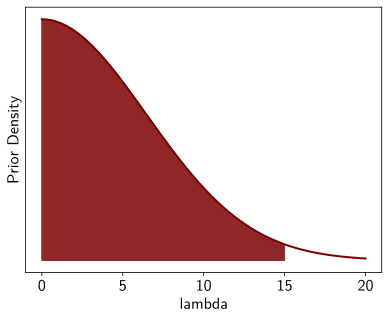

In [9]:
lbda  = np.linspace(0, 20, num=int(20/0.001))

plt.plot(lbda, stats.norm(loc=0,scale=6.44787).pdf(lbda), c=c_dark_highlight, lw=2)
plt.xlabel("lambda"); plt.ylabel("Prior Density"); plt.yticks([]);

lbda99 = np.linspace(0, 15, num=int(15/0.001))
plt.fill_between(lbda99,0.,y2=stats.norm(loc=0,scale=6.44787).pdf(lbda99),color=c_dark);

!mkdir -p ./fig/
plt.savefig("fig/prior-density-lambda.svg", bbox_inches="tight");

In [10]:
!inkscape fig/prior-density-lambda.svg --export-filename=fig/prior-density-lambda.pdf 2>/dev/null

#### Model

In this case, the candidate _complete Bayesian model_ under consideration is given by

$$
\pi( y_{1}, \ldots, y_{N}, \lambda )
=
\left[ \prod_{n = 1}^{N} \text{Poisson} (y_{n} \mid \lambda) \right]
\cdot \text{HalfNormal} (\lambda \mid 6).
$$

<div>
<center>    
<img src="https://github.com/betanalpha/knitr_case_studies/raw/master/principled_bayesian_workflow/figures/iter1/dgm/dgm.png" alt="Drawing" width="40%"/></center>
</div>

In [11]:
N = 1000
R = 500

def model(y=None):
    lbda = numpyro.sample("lbda", dist.HalfNormal(6.44787))
    return numpyro.sample("y", dist.Poisson(lbda).expand([N]), obs=y)

#### Simulation

In [12]:
trace = Predictive(model, {}, num_samples=R)(jax.random.PRNGKey(0))

In [13]:
simu_lbdas = trace['lbda']
simu_ys = trace['y']

In [14]:
print(simu_lbdas[0:9])
print(simu_lbdas.shape)

[0.3952344 8.965513  3.5787933 6.502737  0.5589886 1.4706749 1.5503553
 3.8325102 4.2442613]
(500,)


In [15]:
print(simu_ys[0:9])
print(simu_ys.shape)

[[ 1  0  0 ...  0  1  0]
 [ 7 13  4 ... 11 11 11]
 [ 1  5  6 ...  2  3  2]
 ...
 [ 0  1  3 ...  3  2  4]
 [ 6  3  4 ...  4  1  4]
 [ 4  6  3 ...  8  4  3]]
(500, 1000)


### Plot prior predictive distribution

In [16]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys)

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

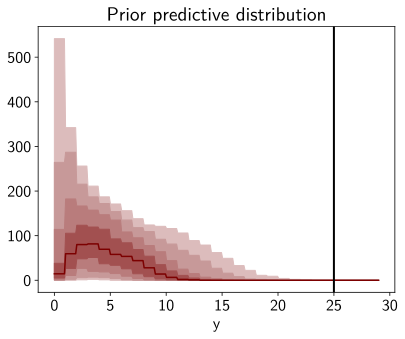

In [17]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

### Fit to simulated data

[Betancourt, 2020](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html#Step_Nine:_Fit_Simulated_Ensemble60) performs this for each `y` in trace.

In [18]:
mcmc = MCMC(NUTS(model), num_warmup=4 * R, num_samples=R, num_chains=2)
mcmc.run(jax.random.PRNGKey(1), y=simu_ys[-1, :])
trace = mcmc.get_samples(group_by_chain=True)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

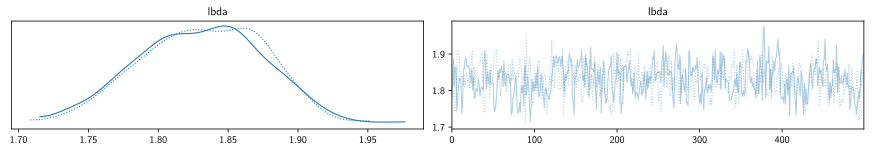

In [19]:
az.plot_trace(trace);

### Fit observations and evaluate

In [20]:
# df = pd.read_csv('data.csv')
data_ys = df[df['data']=='y']['value'].values

In [21]:
mcmc = MCMC(NUTS(model), num_warmup=4 * R, num_samples=R, num_chains=4)
mcmc.run(jax.random.PRNGKey(2), y=data_ys)
trace = mcmc.get_samples(group_by_chain=True)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

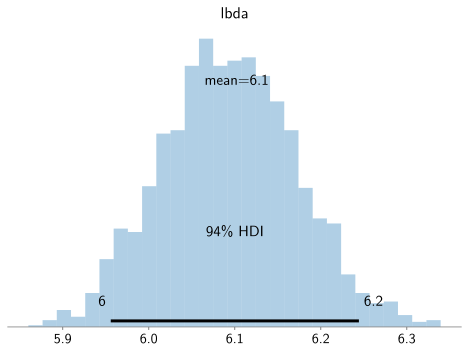

In [22]:
az.plot_posterior(trace, kind="hist");

In [23]:
ppc = Predictive(model, mcmc.get_samples())(jax.random.PRNGKey(3))

In [24]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, ppc['y'])

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

data_hist = np.histogram(data_ys,bins=bins)[0]
data_hist_interp = np.repeat(data_hist, 10)

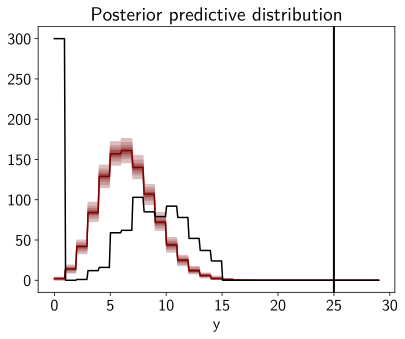

In [25]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.plot(bin_interp,data_hist_interp,color='black');
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Posterior predictive distribution');

## Account for measurement device failure

<!-- 4.2 -->

### Update the generative model specification

Recall the specification of our first attempt to model the detector count data with a [simple Poisson process model](poisson-process-for-arbitrary-detector-count-data)
```python
N = 1000
R = 500

def model(y=None):
    lbda = numpyro.sample("lbda", dist.HalfNormal(6.44787))
    return numpyro.sample("y", dist.Poisson(lbda).expand([N]), obs=y)
```
Here we adapt our likelihood to include a so-called "zero-inflated Poisson distribution" to account for the presence of many $0$ counts that may derive from malfunctioning detector devices.

In [26]:
N = 1000
R = 1000

def model2(y=None):
    theta = numpyro.sample("theta", dist.Beta(1, 1))
    lambda_ = numpyro.sample("lambda", dist.HalfNormal(6.44787))
    return numpyro.sample(
        "y", dist.ZeroInflatedPoisson(rate=lambda_, gate=1 - theta).expand([N]), obs=y)

### Simulate the updated model

In [27]:
trace = Predictive(model2, {}, num_samples=R)(jax.random.PRNGKey(0))

In [28]:
trace["theta"][:10]

DeviceArray([0.8672242 , 0.31337017, 0.5007059 , 0.5511668 , 0.38925606,
             0.67563814, 0.42280847, 0.01797002, 0.11194658, 0.9298568 ],            dtype=float32)

In [29]:
trace["lambda"][:10]

DeviceArray([ 8.611058 ,  1.9441426,  8.545718 ,  4.5276327,  8.939901 ,
              2.550708 ,  5.51275  , 12.968494 ,  3.57722  ,  7.292247 ],            dtype=float32)

In [30]:
simu_ys = trace["y"]
simu_ys

DeviceArray([[ 6, 13, 12, ..., 10, 10, 10],
             [ 3,  2,  1, ...,  3,  0,  0],
             [13,  9,  9, ...,  0,  0, 14],
             ...,
             [ 7,  0,  0, ...,  5,  0,  0],
             [ 5,  4,  0, ...,  0,  0,  0],
             [ 0,  0,  0, ...,  1,  1,  0]], dtype=int32)

What is the fraction of zero values in this simulated data?

In [31]:
simu_ys[simu_ys < 0.001].size / simu_ys.size

0.567505

In [32]:
print(simu_ys.shape)
np.count_nonzero(simu_ys, axis=1).mean()

(1000, 1000)


432.495

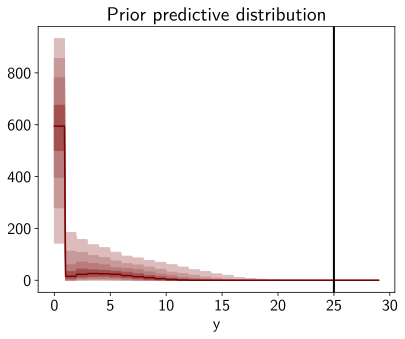

In [33]:
x_max = 30
bins = np.arange(0 ,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)

hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys)

prctiles = np.percentile(hists,np.linspace(10, 90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)


for i, color in enumerate([c_light, c_light_highlight, c_mid, c_mid_highlight]):
    plt.fill_between(bin_interp, prctiles_interp[i, :],
                     prctiles_interp[-1 - i, :],
                     alpha = 1.0,
                     color = color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

In [34]:
simu_ys[simu_ys > 25].size / simu_ys.size

0.000294

### Fit Simulated Observations and Evaluate 

In [35]:
N = 1000
R = 1000

mcmc = MCMC(NUTS(model2), num_warmup=R, num_samples=R, num_chains=2)
mcmc.run(jax.random.PRNGKey(1), y=simu_ys[-1, :])
trace_fit = mcmc.get_samples(group_by_chain=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

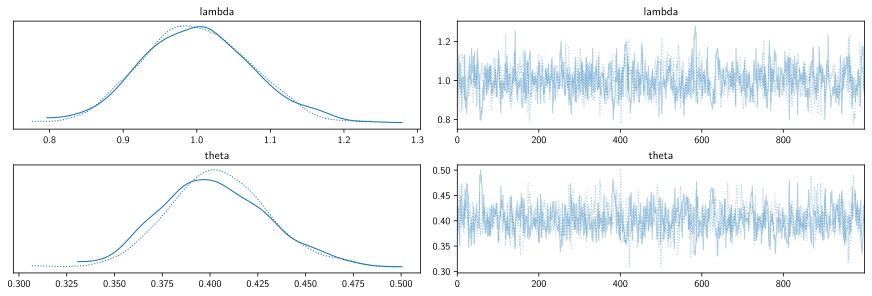

In [36]:
az.plot_trace(trace_fit);

In [37]:
numpyro.diagnostics.print_summary(trace_fit)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    lambda      1.00      0.08      1.00      0.88      1.12    720.29      1.00
     theta      0.40      0.03      0.40      0.36      0.45    636.47      1.00



In [38]:
import pickle
with open("fit_data2.pkl", "wb+") as buffer:
    pickle.dump({"model": model2, "trace": trace_fit}, buffer)

### Fit observations and evaluate

In [39]:
mcmc = MCMC(NUTS(model2), num_warmup=4 * R, num_samples=R, num_chains=4)
mcmc.run(jax.random.PRNGKey(2), y=data_ys)
trace = mcmc.get_samples(group_by_chain=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

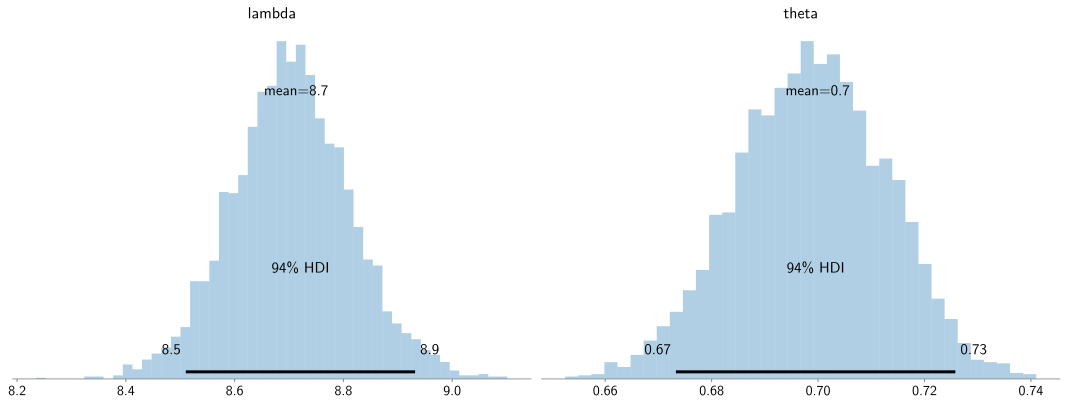

In [40]:
az.plot_posterior(trace, kind="hist");

In [41]:
ppc = Predictive(model2, mcmc.get_samples())(jax.random.PRNGKey(3))

In [42]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, ppc['y'])

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

data_hist = np.histogram(data_ys,bins=bins)[0]
data_hist_interp = np.repeat(data_hist, 10)

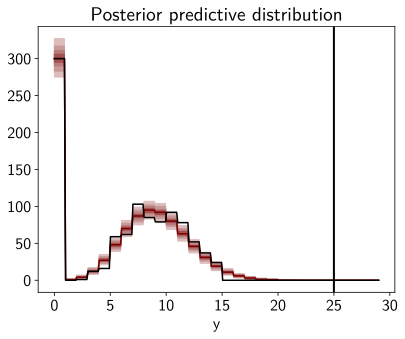

In [43]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.plot(bin_interp,data_hist_interp,color='black');
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Posterior predictive distribution');

## Account for the distinction between functioning and malfunctioning measurement devices
<!-- 4.3 -->

### Update the generative model

Build a model that generates zero-inflated Poisson counts and update the `HalfNormal` prior, which, in combination with the zero-inflated Poisson distribution, leaves too much probability mass near zero. Here we use an `InverseGamma` prior with hyperparameter settings that leave $\approx 1\%$ of the probability mass below a detector count of $1$ and similarly allows for $\approx 1\%$ of the mass above $15$. $1$ and $15$ are on the arbitrary integral detector count scale implied here by knowledge of the manufacturing specifications of the hypothetical detector devices.

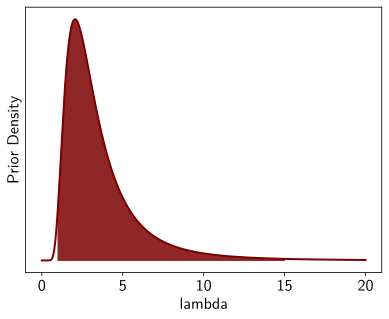

In [44]:
lbda  = np.linspace(0, 20, num=int(20/0.001))
pdf = stats.invgamma(3.48681,scale=9.21604)
plt.plot(lbda, pdf.pdf(lbda), c=c_dark_highlight, lw=2)
plt.xlabel("lambda"); plt.ylabel("Prior Density"); plt.yticks([]);

lbda99 = np.linspace(1, 15, num=int(15/0.001))

plt.fill_between(lbda99,0.,y2=pdf.pdf(lbda99),color=c_dark);

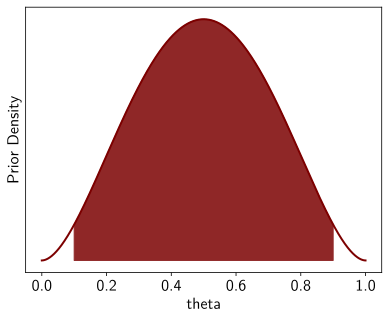

In [45]:
theta  = np.linspace(0, 1, num=int(1/0.001))
pdf = stats.beta(2.8663,2.8663)
plt.plot(theta, pdf.pdf(theta), c=c_dark_highlight, lw=2)
plt.xlabel("theta"); plt.ylabel("Prior Density"); plt.yticks([]);

theta99 = np.linspace(0.1, 0.9, num=int(0.8/0.001))

plt.fill_between(theta99,0.,y2=pdf.pdf(theta99),color=c_dark);

 For reference, the model from the second attempt is
```python
N = 1000
R = 1000

def model2(y=None):
    lbda = numpyro.sample("lbda", dist.HalfNormal(6.44787))
    theta = numpyro.sample("theta", dist.Beta(1, 1))
    return numpyro.sample(
        "y", dist.ZeroInflatedPoisson(rate=lbda, gate=1 - theta).expand([N]), obs=y)
```


In [46]:
N = 1000
R = 1000

def model3(y=None):
    lbda = numpyro.sample("lbda", dist.InverseGamma(3.48681, 9.21604))
    theta = numpyro.sample("theta", dist.Beta(2.8663, 2.8663))  
    return numpyro.sample(
        "y", dist.ZeroInflatedPoisson(rate=lbda, gate=1 - theta).expand([N]), obs=y)

In [47]:
trace = Predictive(model3, {}, num_samples=R)(jax.random.PRNGKey(0))

In [48]:
simu_lbdas = trace['lbda']
simu_thetas = trace['theta']
simu_ys = trace['y']

### Plot prior predictive distribution

In [49]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys)

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

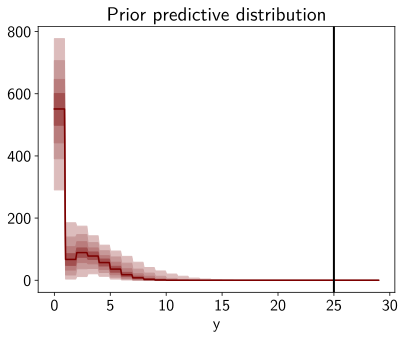

In [50]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

### Fit to simulated data

In the example, Betancourt performs this for each `y` in trace. Here we only compute this for one element of the trace.

In [51]:
N = 1000
R = 1000

mcmc = MCMC(NUTS(model3), num_warmup=4 * R, num_samples=R, num_chains=2)
mcmc.run(jax.random.PRNGKey(1), y=simu_ys[:, -1])
trace = mcmc.get_samples(group_by_chain=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

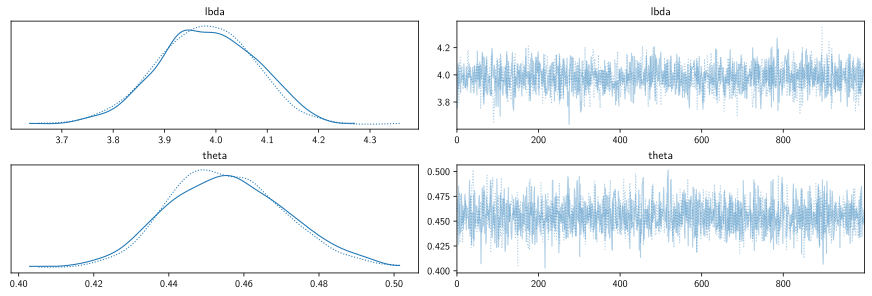

In [52]:
az.plot_trace(trace);

### Fit observations and evaluate

In [53]:
# df = pd.read_csv('data.csv')
data_ys = df[df['data']=='y']['value'].values

In [54]:
mcmc = MCMC(NUTS(model3), num_warmup=4 * R, num_samples=R, num_chains=4)
mcmc.run(jax.random.PRNGKey(2), y=data_ys)
trace = mcmc.get_samples(group_by_chain=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

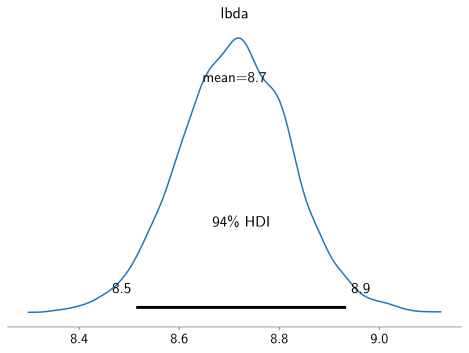

In [55]:
az.plot_posterior(trace, var_names="lbda");

In [56]:
ppc = Predictive(model3, mcmc.get_samples())(jax.random.PRNGKey(3))

In [57]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, ppc['y'])

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

data_hist = np.histogram(data_ys,bins=bins)[0]
data_hist_interp = np.repeat(data_hist, 10)

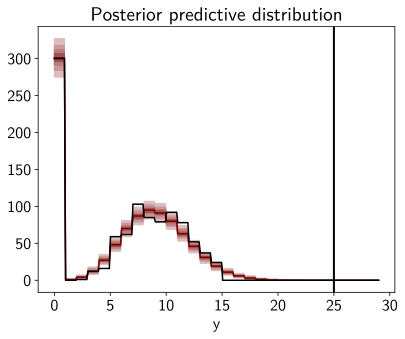

In [58]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.plot(bin_interp,data_hist_interp,color='black');
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Posterior predictive distribution');

## Account for upper limit of detection

The results of our third attempt identified the fact that a feature missing from our prior was an upper threshold beyond which detectors were unable to register counts. Now, we implement a means of truncating the zero-inflated Poisson distribution, see `TruncatedZeroInflatedPoisson` below to reflect this newly recognized domain expertise. In principle, if we had done a better job of thinking through the physical constraints of this experiment, we could have identified this as an appropriate model in step one. In practice, there will almost always be something of this nature that is not accounted for in the initial incorporation of domain expertise into the model structure.

In [59]:
def rv_truncated_poisson(mu, mx, size=None):
    mu = np.asarray(mu)
    mx = np.asarray(mx)
    dist = stats.distributions.poisson(mu)

    lower_cdf = 0.
    upper_cdf = dist.cdf(mx)
    nrm = upper_cdf - lower_cdf
    sample = np.random.random(size) * nrm + lower_cdf

    return dist.ppf(sample)


def rv_truncated_zip(args):
    rate, gate, high, shape = args
    g = rv_truncated_poisson(rate, high, size=shape)
    return g * (np.random.random(shape) > gate)


class TruncatedZeroInflatedPoisson(dist.Distribution):

    def __init__(self, rate, gate, high, validate_args=None):
        self.rate, self.gate, self.high = rate, gate, high
        batch_shape = jax.lax.broadcast_shapes(
            jnp.shape(rate), jnp.shape(gate), jnp.shape(high))
        super().__init__(batch_shape, validate_args=None)

    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        samples = jax.experimental.host_callback.call(
            rv_truncated_zip, (self.rate, self.gate, self.high, shape),
            result_shape=jax.ShapeDtypeStruct(shape, jnp.result_type(float)))
        return samples.astype(jnp.result_type(int))

    def log_prob(self, value):
        upper_cdf = jax.scipy.special.gammaincc(self.high + 1, self.rate)
        log_prob = dist.Poisson(self.rate).log_prob(value) - jnp.log(upper_cdf)
        log_prob = jnp.log1p(-self.gate) + log_prob
        return jnp.where(value == 0, jnp.log(self.gate + jnp.exp(log_prob)), log_prob)

Our previous model (attempt number three) was based on the `ZeroInflatedPoisson` without truncation.
```python
N = 1000
R = 1000

def model3(y=None):
    lbda = numpyro.sample("lbda", dist.InverseGamma(3.48681, 9.21604))
    theta = numpyro.sample("theta", dist.Beta(2.8663, 2.8663))  
    return numpyro.sample(
        "y", dist.ZeroInflatedPoisson(rate=lbda, gate=1 - theta).expand([N]), obs=y)
```

In [60]:
N = 1000
R = 1000

def model4(y=None):
    lbda = numpyro.sample("lbda", dist.InverseGamma(3.48681, 9.21604))
    theta = numpyro.sample("theta", dist.Beta(2.8663, 2.8663))  
    return numpyro.sample(
        "y",
        TruncatedZeroInflatedPoisson(rate=lbda, gate=1 - theta, high=14).expand([N]),
        obs=y)

In [61]:
trace = Predictive(model4, {}, num_samples=1000)(jax.random.PRNGKey(0))

In [62]:
simu_lbdas = trace['lbda']
simu_thetas = trace['theta']
simu_ys = trace['y']

In [63]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys)

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

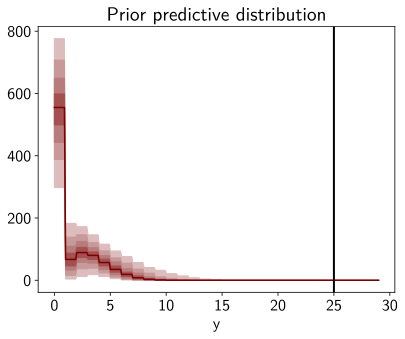

In [64]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

In [65]:
N = 1000
R = 1000

mcmc = MCMC(NUTS(model4), num_warmup=4 * R, num_samples=R, num_chains=4)
mcmc.run(jax.random.PRNGKey(1), y=data_ys)
trace = mcmc.get_samples(group_by_chain=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

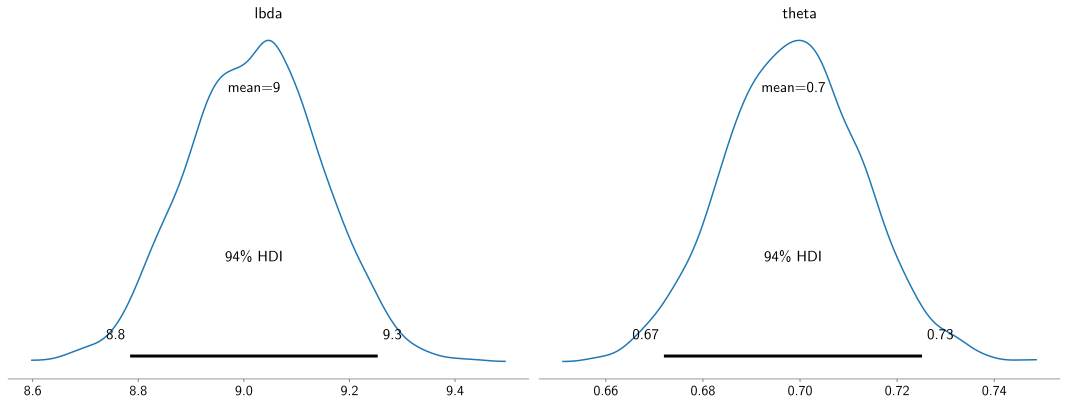

In [66]:
az.plot_posterior(trace);

In [67]:
ppc = Predictive(model4, mcmc.get_samples())(jax.random.PRNGKey(2))

In [68]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, ppc['y'])

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

data_hist = np.histogram(data_ys,bins=bins)[0]
data_hist_interp = np.repeat(data_hist, 10)

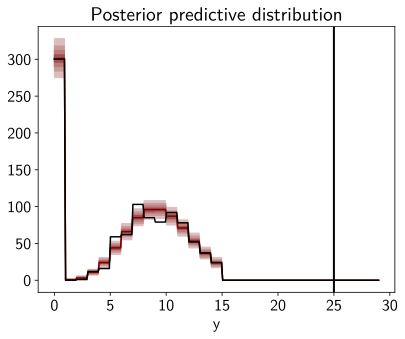

In [69]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.plot(bin_interp,data_hist_interp,color='black');
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Posterior predictive distribution');